In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily
import holidays

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, LayerNormalization, Normalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
df = pd.read_csv("Traffic_Volume_Counts_20250324.csv")
df["Date"] = pd.to_datetime(df["Date"])
hourly_cols = [col for col in df.columns if ":" in col]
df["Daily_Traffic"] = df[hourly_cols].sum(axis=1)
df = df[["Date", "Daily_Traffic"]].dropna()
df.set_index("Date", inplace=True)

In [19]:
us_holidays = holidays.US()
df["Holiday"] = df.index.to_series().apply(lambda date: 1 if date in us_holidays else 0)

In [20]:
nyc = Point(40.7128, -74.0060)
weather = Daily(nyc, df.index.min(), df.index.max()).fetch()
df = df.join(weather[["tavg", "prcp", "wspd"]].interpolate())
df = df.dropna()

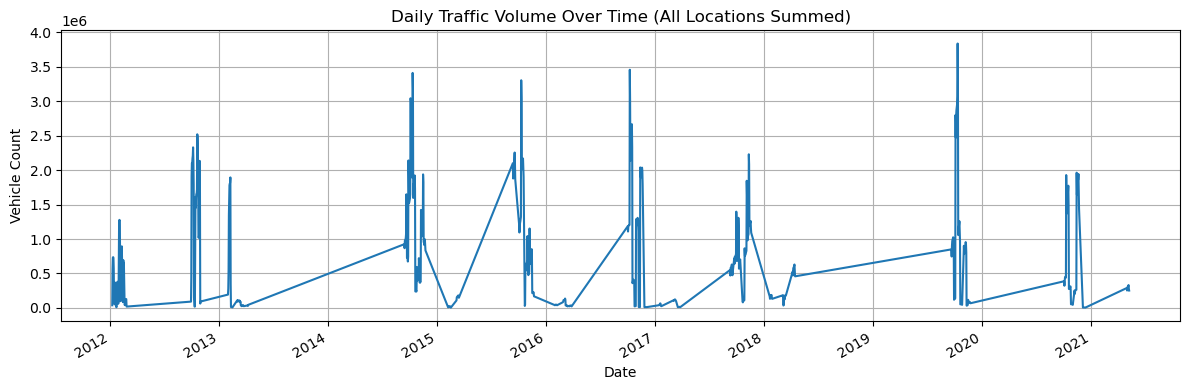

In [21]:
# Time Series Plot
df_grouped = df.groupby(df.index).agg({'Daily_Traffic': 'sum'})
plt.figure(figsize=(12, 4))
df_grouped['Daily_Traffic'].plot()
plt.title("Daily Traffic Volume Over Time (All Locations Summed)")
plt.ylabel("Vehicle Count")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

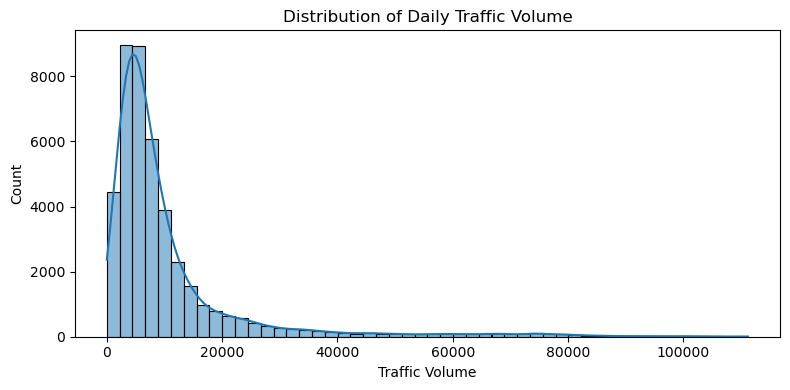

In [22]:
# Distribution Plot
plt.figure(figsize=(8, 4))
sns.histplot(df['Daily_Traffic'], bins=50, kde=True)
plt.title("Distribution of Daily Traffic Volume")
plt.xlabel("Traffic Volume")
plt.tight_layout()
plt.show()

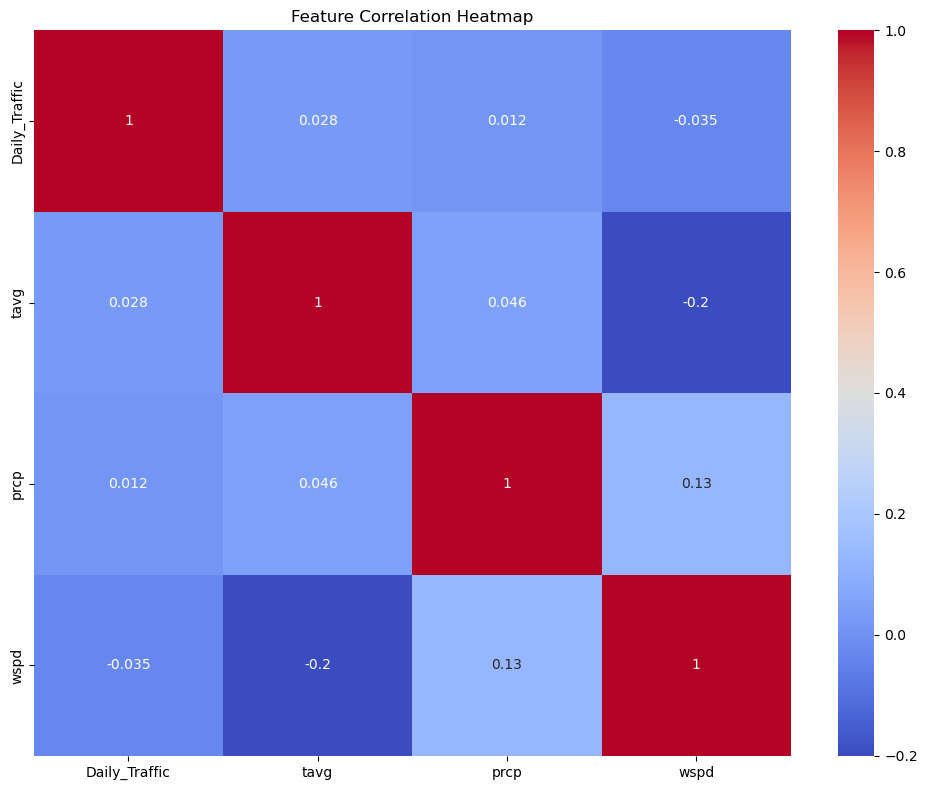

In [23]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Daily_Traffic','tavg', 'prcp', 'wspd']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [24]:
def create_sequences(data, features, target, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[features].iloc[i-window:i].values)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

In [25]:
features = ['Daily_Traffic', 'Holiday', 'tavg', 'prcp', 'wspd']
X, y = create_sequences(df, features, 'Daily_Traffic', window=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [26]:
normalizer = Normalization()
normalizer.adapt(X_train)

In [27]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    normalizer,
    SimpleRNN(64),
    LayerNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=[early_stop])


Epoch 1/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 357713728.0000 - val_loss: 69251832.0000
Epoch 2/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 246719376.0000 - val_loss: 41636708.0000
Epoch 3/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 173673008.0000 - val_loss: 27137954.0000
Epoch 4/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 145634832.0000 - val_loss: 22867998.0000
Epoch 5/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 128468688.0000 - val_loss: 21223456.0000
Epoch 6/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 127165736.0000 - val_loss: 19020386.0000
Epoch 7/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 114457240.0000 - val_loss: 17779824.0000
Epoch 8/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 113051384.0000 - val_loss: 18226750.0000
Epoch 9/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 113753784.0000 - val_loss: 17878448.0000
Epoch 10/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 120214824.0000 - val

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


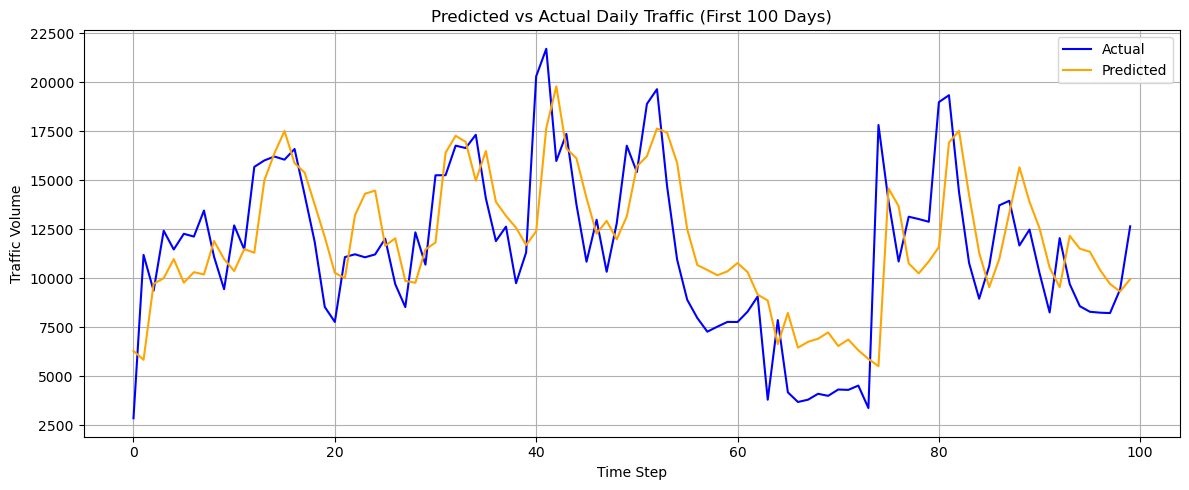

In [28]:
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='orange')
plt.title("Predicted vs Actual Daily Traffic (First 100 Days)")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

RMSE: 3164.56
MAE : 2366.95


In [30]:
# Choose a sample index
index = 10 
# Get the input sequence
sample_input = X_test[index:index+1] 

# Predict
predicted_traffic = model.predict(sample_input).flatten()[0]

# Actual value
actual_traffic = y_test[index]

print(f"Custom Prediction at index {index}:")
print(f"Predicted Traffic Volume: {predicted_traffic:.2f}")
print(f"Actual Traffic Volume   : {actual_traffic:.2f}")
print(f"Absolute Error           : {abs(predicted_traffic - actual_traffic):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Custom Prediction at index 10:
Predicted Traffic Volume: 10377.04
Actual Traffic Volume   : 12704.00
Absolute Error           : 2326.96
